## Implementation of DeiT - Data Efficient Image Transformer

### Name: Vignesh Ram Ramesh Kutti
### ANo: A20548747

### Name: Aravind Balaji Srinivasan
### ANo: A20563386

In [1]:
import torch
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0))  


True
NVIDIA GeForce GTX 1650


In [2]:
%run transformer_models.py


In [3]:
%run transformer_models_deit.py

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations for CIFAR-10
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # CIFAR-10 is 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalization
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
from transformer_models import VisionTransformer

model = VisionTransformer().to(device)


In [6]:
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy, MulticlassAUROC, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

# Define metrics
num_classes = 10  # For CIFAR-10
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
auc_metric = MulticlassAUROC(num_classes=num_classes).to(device)
f1_metric = MulticlassF1Score(num_classes=num_classes).to(device)
precision_metric = MulticlassPrecision(num_classes=num_classes).to(device)
recall_metric = MulticlassRecall(num_classes=num_classes).to(device)
top1_accuracy_metric = MulticlassAccuracy(num_classes=num_classes, top_k=1).to(device)
top5_accuracy_metric = MulticlassAccuracy(num_classes=num_classes, top_k=5).to(device)


In [7]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    
    # Reset metric values
    accuracy_metric.reset()
    auc_metric.reset()
    f1_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    top1_accuracy_metric.reset()
    top5_accuracy_metric.reset()

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs.argmax(1) # Predictions for metrics like accuracy, F1, precision, and recall
        probs = torch.softmax(outputs, dim=1)  # Probabilities for AUC
        
        # Update metrics
        accuracy_metric.update(preds, labels)
        auc_metric.update(probs, labels)
        f1_metric.update(preds, labels)
        precision_metric.update(preds, labels)
        recall_metric.update(preds, labels)
        top1_accuracy_metric.update(outputs, labels)
        top5_accuracy_metric.update(outputs, labels)

    avg_loss = total_loss / len(dataloader)
    train_accuracy = accuracy_metric.compute()
    train_auc = auc_metric.compute()
    train_f1 = f1_metric.compute()
    train_precision = precision_metric.compute()
    train_recall = recall_metric.compute()
    train_top1_accuracy = top1_accuracy_metric.compute().item()
    train_top5_accuracy = top5_accuracy_metric.compute().item()
    
    return avg_loss, train_accuracy.item(), train_auc.item(), train_f1.item(), train_precision.item(), train_recall.item(), train_top1_accuracy, train_top5_accuracy


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    
    # Reset metric values
    accuracy_metric.reset()
    auc_metric.reset()
    f1_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    top1_accuracy_metric.reset()
    top5_accuracy_metric.reset()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            preds = outputs.argmax(1)
            probs = torch.softmax(outputs, dim=1)  # Probabilities for AUC
            
            # Update metrics
            accuracy_metric.update(preds, labels)
            auc_metric.update(probs, labels)
            f1_metric.update(preds, labels)
            precision_metric.update(preds, labels)
            recall_metric.update(preds, labels)
            top1_accuracy_metric.update(outputs, labels)
            top5_accuracy_metric.update(outputs, labels)

    avg_loss = total_loss / len(dataloader)
    val_accuracy = accuracy_metric.compute()
    val_auc = auc_metric.compute()
    val_f1 = f1_metric.compute()
    val_precision = precision_metric.compute()
    val_recall = recall_metric.compute()
    val_top1_accuracy = top1_accuracy_metric.compute().item()
    val_top5_accuracy = top5_accuracy_metric.compute().item()
    
    return avg_loss, val_accuracy.item(), val_auc.item(), val_f1.item(), val_precision.item(), val_recall.item(),  val_top1_accuracy, val_top5_accuracy


In [8]:
# # Hyperparameters
num_epochs = 20
learning_rate = 0.001

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training and validation history for all metrics
train_losses, train_accuracies, train_aucs, train_f1s, train_precisions, train_recalls = [], [], [], [], [], []
train_top1_accuracies, train_top5_accuracies = [], []
val_losses, val_accuracies, val_aucs, val_f1s, val_precisions, val_recalls = [], [], [], [], [], []
val_top1_accuracies, val_top5_accuracies = [], []  

# Training the Vision Transformer on CIFAR-10
for epoch in range(num_epochs):
    train_loss, train_accuracy, train_auc, train_f1, train_precision, train_recall, train_top1_accuracy, train_top5_accuracy = train(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy, val_auc, val_f1, val_precision, val_recall, val_top1_accuracy, val_top5_accuracy = evaluate(model, test_loader, criterion)
    
    # Store history
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_aucs.append(train_auc)
    train_f1s.append(train_f1)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_top1_accuracies.append(train_top1_accuracy)
    train_top5_accuracies.append(train_top5_accuracy)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_aucs.append(val_auc)
    val_f1s.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_top1_accuracies.append(val_top1_accuracy)
    val_top5_accuracies.append(val_top5_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Train AUC: {train_auc:.4f}, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f},"
          f"Train Top-1 Acc: {train_top1_accuracy:.4f}, Train Top-5 Acc: {train_top5_accuracy:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, "
          f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val Top-1 Acc: {val_top1_accuracy:.4f}, "
          f"Val Top-5 Acc: {val_top5_accuracy:.4f}")


Epoch [1/20] - Train Loss: 1.8012, Train Acc: 0.3386, Train AUC: 0.7944, Train F1: 0.3306, Train Precision: 0.3299, Train Recall: 0.3386,Train Top-1 Acc: 0.3386, Train Top-5 Acc: 0.8362 - Val Loss: 1.5399, Val Acc: 0.4466, Val AUC: 0.8619, Val F1: 0.4380, Val Precision: 0.4597, Val Recall: 0.4466, Val Top-1 Acc: 0.4466, Val Top-5 Acc: 0.9076
Epoch [2/20] - Train Loss: 1.4649, Train Acc: 0.4699, Train AUC: 0.8716, Train F1: 0.4667, Train Precision: 0.4659, Train Recall: 0.4699,Train Top-1 Acc: 0.4699, Train Top-5 Acc: 0.9185 - Val Loss: 1.3478, Val Acc: 0.5126, Val AUC: 0.8944, Val F1: 0.5090, Val Precision: 0.5137, Val Recall: 0.5126, Val Top-1 Acc: 0.5126, Val Top-5 Acc: 0.9345
Epoch [3/20] - Train Loss: 1.2987, Train Acc: 0.5309, Train AUC: 0.9003, Train F1: 0.5289, Train Precision: 0.5280, Train Recall: 0.5309,Train Top-1 Acc: 0.5309, Train Top-5 Acc: 0.9401 - Val Loss: 1.2492, Val Acc: 0.5448, Val AUC: 0.9106, Val F1: 0.5441, Val Precision: 0.5550, Val Recall: 0.5448, Val Top-1 Acc

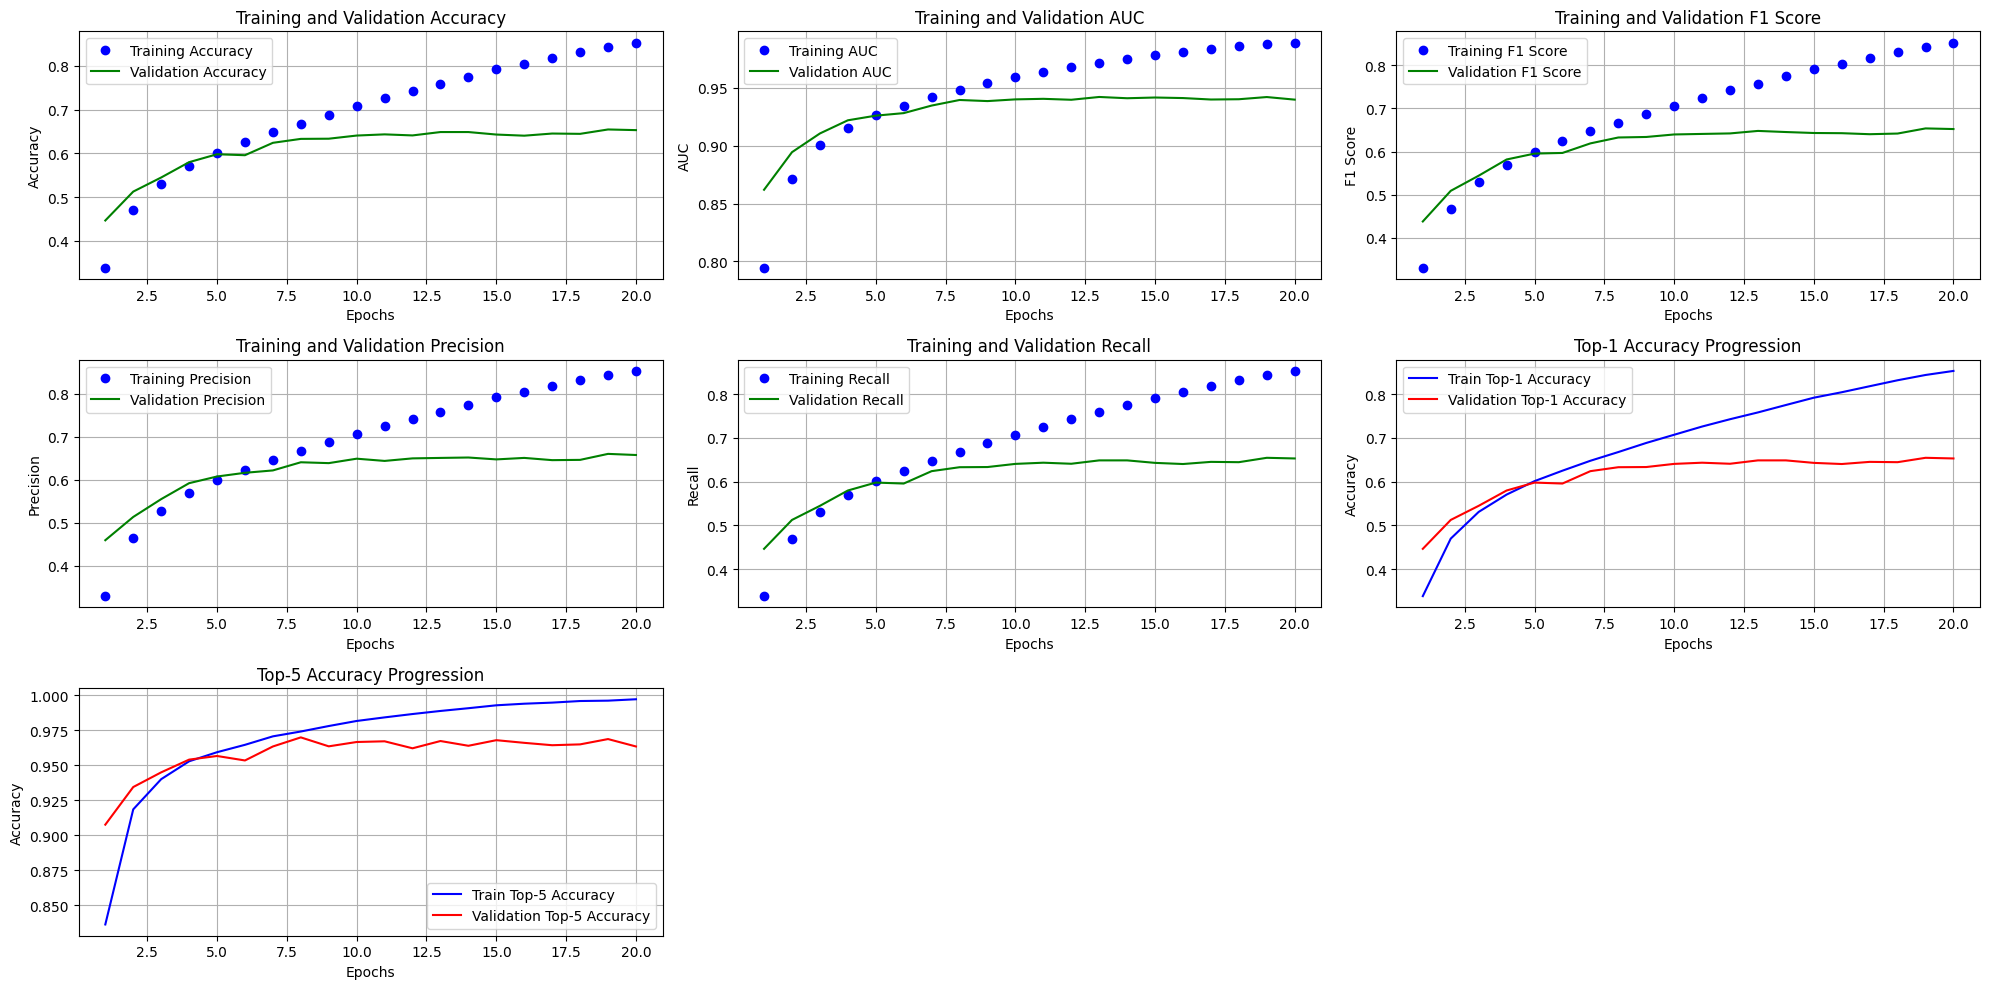

In [9]:
import matplotlib.pyplot as plt

# Plot Accuracy, AUC, F1 Score, Precision, Recall
plt.figure(figsize=(20, 10))

# Plot Accuracy
plt.subplot(3, 3, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'bo', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'g', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Plot AUC
plt.subplot(3, 3, 2)
plt.plot(range(1, num_epochs + 1), train_aucs, 'bo', label='Training AUC')
plt.plot(range(1, num_epochs + 1), val_aucs, 'g', label='Validation AUC')
plt.title("Training and Validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.grid(True)
plt.legend()

# Plot F1 Score
plt.subplot(3, 3, 3)
plt.plot(range(1, num_epochs + 1), train_f1s, 'bo', label='Training F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1s, 'g', label='Validation F1 Score')
plt.title("Training and Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()

# Plot Precision
plt.subplot(3, 3, 4)
plt.plot(range(1, num_epochs + 1), train_precisions, 'bo', label='Training Precision')
plt.plot(range(1, num_epochs + 1), val_precisions, 'g', label='Validation Precision')
plt.title("Training and Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()

# Plot Recall
plt.subplot(3, 3, 5)
plt.plot(range(1, num_epochs + 1), train_recalls, 'bo', label='Training Recall')
plt.plot(range(1, num_epochs + 1), val_recalls, 'g', label='Validation Recall')
plt.title("Training and Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 6)
plt.plot(range(1, num_epochs + 1), train_top1_accuracies, 'b-', label='Train Top-1 Accuracy')
plt.plot(range(1, num_epochs + 1), val_top1_accuracies, 'r-', label='Validation Top-1 Accuracy')
plt.title("Top-1 Accuracy Progression")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Plot Top-5 Accuracy
plt.subplot(3, 3, 7)
plt.plot(range(1, num_epochs + 1), train_top5_accuracies, 'b-', label='Train Top-5 Accuracy')
plt.plot(range(1, num_epochs + 1), val_top5_accuracies, 'r-', label='Validation Top-5 Accuracy')
plt.title("Top-5 Accuracy Progression")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()


### Data Efficient Image Transformer (Teacher: ResNet-50)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations for CIFAR-10
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # CIFAR-10 is 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalization
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
from transformer_models_deit import DistilledVisionTransformer

# Instantiate the DeiT model
student_model = DistilledVisionTransformer().to(device)


#### Load the ResNet-50 Teacher Model

In [12]:
# Load and prepare the ResNet-50 teacher model
teacher_model = torchvision.models.resnet50(pretrained=True)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)  # Modify the last layer for CIFAR-10

# Ensure the entire model is on the GPU
teacher_model = teacher_model.to(device)
teacher_model.eval()  # Set teacher model to evaluation mode



F:\vision_transformer_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\vision_transformer_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.5, temperature=3.0):
        super().__init__()
        self.alpha = alpha #lambda
        self.temperature = temperature
        self.criterion_ce = nn.CrossEntropyLoss()
        self.criterion_kl = nn.KLDivLoss(reduction="batchmean") 

    def forward(self, student_logits, student_distill_logits, teacher_logits, labels):
        ce_loss = self.criterion_ce(student_logits, labels)
        distill_loss = self.criterion_kl(
            nn.functional.log_softmax(student_distill_logits / self.temperature, dim=1),
            nn.functional.softmax(teacher_logits / self.temperature, dim=1)
        )
        return ce_loss * (1 - self.alpha) + distill_loss * self.alpha * self.temperature ** 2


criterion = DistillationLoss(alpha=0.5, temperature=3.0)
optimizer = optim.Adam(student_model.parameters(), lr=0.001)


In [14]:
# Number of classes for CIFAR-10
num_classes = 10

# Define metrics for both training and evaluation
accuracy_metric_deit = MulticlassAccuracy(num_classes=num_classes).to(device)
auc_metric_deit = MulticlassAUROC(num_classes=num_classes).to(device)
f1_metric_deit = MulticlassF1Score(num_classes=num_classes).to(device)
precision_metric_deit = MulticlassPrecision(num_classes=num_classes).to(device)
recall_metric_deit = MulticlassRecall(num_classes=num_classes).to(device)
top1_accuracy_metric_deit = MulticlassAccuracy(num_classes=num_classes, top_k=1).to(device)
top5_accuracy_metric_deit = MulticlassAccuracy(num_classes=num_classes, top_k=5).to(device)

In [15]:
def train_distilled(model, teacher, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    
    # Reset metric values
    accuracy_metric_deit.reset()
    auc_metric_deit.reset()
    f1_metric_deit.reset()
    precision_metric_deit.reset()
    recall_metric_deit.reset()
    top1_accuracy_metric_deit.reset()
    top5_accuracy_metric_deit.reset()

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        # Get teacher's predictions (without gradient tracking)
        with torch.no_grad():
            teacher_logits = teacher(images)
        
        # Forward pass through the student (DeiT) model
        student_logits, student_distill_logits = model(images)
        loss = criterion(student_logits, student_distill_logits, teacher_logits, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()
        
        # Predictions and probabilities for metrics
        preds = student_logits.argmax(dim=1)  # Discrete predictions for accuracy, F1, etc.
        probs = torch.softmax(student_logits, dim=1)  # Probabilities for AUC
        
        # Update metrics
        accuracy_metric_deit.update(preds, labels)
        auc_metric_deit.update(probs, labels)
        f1_metric_deit.update(preds, labels)
        precision_metric_deit.update(preds, labels)
        recall_metric_deit.update(preds, labels)
        top1_accuracy_metric_deit.update(student_logits, labels)
        top5_accuracy_metric_deit.update(student_logits, labels)

    # Calculate average metrics for the epoch
    avg_loss_deit = total_loss / len(dataloader)
    train_accuracy_deit = accuracy_metric_deit.compute()
    train_auc_deit = auc_metric_deit.compute()
    train_f1_deit = f1_metric_deit.compute()
    train_precision_deit = precision_metric_deit.compute()
    train_recall_deit = recall_metric_deit.compute()
    train_top1_accuracy_deit = top1_accuracy_metric_deit.compute().item()
    train_top5_accuracy_deit = top5_accuracy_metric_deit.compute().item()
    
    return avg_loss_deit, train_accuracy_deit.item(), train_auc_deit.item(), train_f1_deit.item(), train_precision_deit.item(), train_recall_deit.item(),  train_top1_accuracy_deit, train_top5_accuracy_deit


def evaluate_distilled(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    
    # Reset metric values
    accuracy_metric_deit.reset()
    auc_metric_deit.reset()
    f1_metric_deit.reset()
    precision_metric_deit.reset()
    recall_metric_deit.reset()
    top1_accuracy_metric_deit.reset()
    top5_accuracy_metric_deit.reset()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            student_logits, student_distill_logits = model(images)
            loss = criterion(student_logits, student_distill_logits, student_logits, labels)  # Only student outputs are needed for validation
            
            # Accumulate loss
            total_loss += loss.item()
            
            # Predictions and probabilities for metrics
            preds = student_logits.argmax(dim=1)  # Discrete predictions
            probs = torch.softmax(student_logits, dim=1)  # Probabilities for AUC
            
            # Update metrics
            accuracy_metric_deit.update(preds, labels)
            auc_metric_deit.update(probs, labels)
            f1_metric_deit.update(preds, labels)
            precision_metric_deit.update(preds, labels)
            recall_metric_deit.update(preds, labels)
            top1_accuracy_metric_deit.update(student_logits, labels)
            top5_accuracy_metric_deit.update(student_logits, labels)

    # Calculate average metrics for the epoch
    avg_loss_deit = total_loss / len(dataloader)
    val_accuracy_deit = accuracy_metric_deit.compute()
    val_auc_deit = auc_metric_deit.compute()
    val_f1_deit = f1_metric_deit.compute()
    val_precision_deit = precision_metric_deit.compute()
    val_recall_deit = recall_metric_deit.compute()
    val_top1_accuracy_deit = top1_accuracy_metric_deit.compute().item()
    val_top5_accuracy_deit = top5_accuracy_metric_deit.compute().item()
    
    return avg_loss_deit, val_accuracy_deit.item(), val_auc_deit.item(), val_f1_deit.item(), val_precision_deit.item(), val_recall_deit.item(), val_top1_accuracy_deit, val_top5_accuracy_deit



In [16]:
# Lists to store training and validation history for all metrics
train_losses_deit, train_accuracies_deit, train_aucs_deit, train_f1s_deit, train_precisions_deit, train_recalls_deit = [], [], [], [], [], []
val_losses_deit, val_accuracies_deit, val_aucs_deit, val_f1s_deit, val_precisions_deit, val_recalls_deit = [], [], [], [], [], []
train_top1_accuracies_deit, val_top1_accuracies_deit = [], []
train_top5_accuracies_deit, val_top5_accuracies_deit = [], []

num_epochs = 20
for epoch in range(num_epochs):
    train_loss_deit, train_accuracy_deit, train_auc_deit, train_f1_deit, train_precision_deit, train_recall_deit, train_top1_accuracy_deit, train_top5_accuracy_deit = train_distilled(student_model, teacher_model, train_loader, criterion, optimizer)
    val_loss_deit, val_accuracy_deit, val_auc_deit, val_f1_deit, val_precision_deit, val_recall_deit, val_top1_accuracy_deit, val_top5_accuracy_deit = evaluate_distilled(student_model, test_loader, criterion)
    
    # Store history
    train_losses_deit.append(train_loss_deit)
    train_accuracies_deit.append(train_accuracy_deit)
    train_aucs_deit.append(train_auc_deit)
    train_f1s_deit.append(train_f1_deit)
    train_precisions_deit.append(train_precision_deit)
    train_recalls_deit.append(train_recall_deit)
    train_top1_accuracies_deit.append(train_top1_accuracy)
    train_top5_accuracies_deit.append(train_top5_accuracy)
    
    val_losses_deit.append(val_loss_deit)
    val_accuracies_deit.append(val_accuracy_deit)
    val_aucs_deit.append(val_auc_deit)
    val_f1s_deit.append(val_f1_deit)
    val_precisions_deit.append(val_precision_deit)
    val_recalls_deit.append(val_recall_deit)
    val_top1_accuracies_deit.append(val_top1_accuracy)
    val_top5_accuracies_deit.append(val_top5_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss_deit:.4f}, Train Acc: {train_accuracy_deit:.4f}, "
          f"Train AUC: {train_auc_deit:.4f}, Train F1: {train_f1_deit:.4f}, Train Precision: {train_precision_deit:.4f}, Train Recall: {train_recall_deit:.4f} Train Top-1 Acc: {train_top1_accuracy:.4f}, "
          f"Train Top-5 Acc: {train_top5_accuracy:.4f}- "
          f"Val Loss: {val_loss_deit:.4f}, Val Acc: {val_accuracy_deit:.4f}, Val AUC: {val_auc_deit:.4f}, Val F1: {val_f1_deit:.4f}, "
          f"Val Precision: {val_precision_deit:.4f}, Val Recall: {val_recall_deit:.4f}, Val Top-1 Acc: {val_top1_accuracy:.4f}, "
          f"Val Top-5 Acc: {val_top5_accuracy:.4f}")


Epoch [1/20] - Train Loss: 0.9338, Train Acc: 0.3448, Train AUC: 0.7991, Train F1: 0.3389, Train Precision: 0.3396, Train Recall: 0.3448 Train Top-1 Acc: 0.8529, Train Top-5 Acc: 0.9973- Val Loss: 1.3686, Val Acc: 0.4541, Val AUC: 0.8689, Val F1: 0.4381, Val Precision: 0.4562, Val Recall: 0.4541, Val Top-1 Acc: 0.6530, Val Top-5 Acc: 0.9635
Epoch [2/20] - Train Loss: 0.7596, Train Acc: 0.4786, Train AUC: 0.8754, Train F1: 0.4751, Train Precision: 0.4742, Train Recall: 0.4786 Train Top-1 Acc: 0.8529, Train Top-5 Acc: 0.9973- Val Loss: 1.5277, Val Acc: 0.5082, Val AUC: 0.8909, Val F1: 0.5035, Val Precision: 0.5136, Val Recall: 0.5082, Val Top-1 Acc: 0.6530, Val Top-5 Acc: 0.9635
Epoch [3/20] - Train Loss: 0.6905, Train Acc: 0.5283, Train AUC: 0.8985, Train F1: 0.5261, Train Precision: 0.5251, Train Recall: 0.5283 Train Top-1 Acc: 0.8529, Train Top-5 Acc: 0.9973- Val Loss: 1.6222, Val Acc: 0.5422, Val AUC: 0.9072, Val F1: 0.5404, Val Precision: 0.5611, Val Recall: 0.5422, Val Top-1 Acc: 0

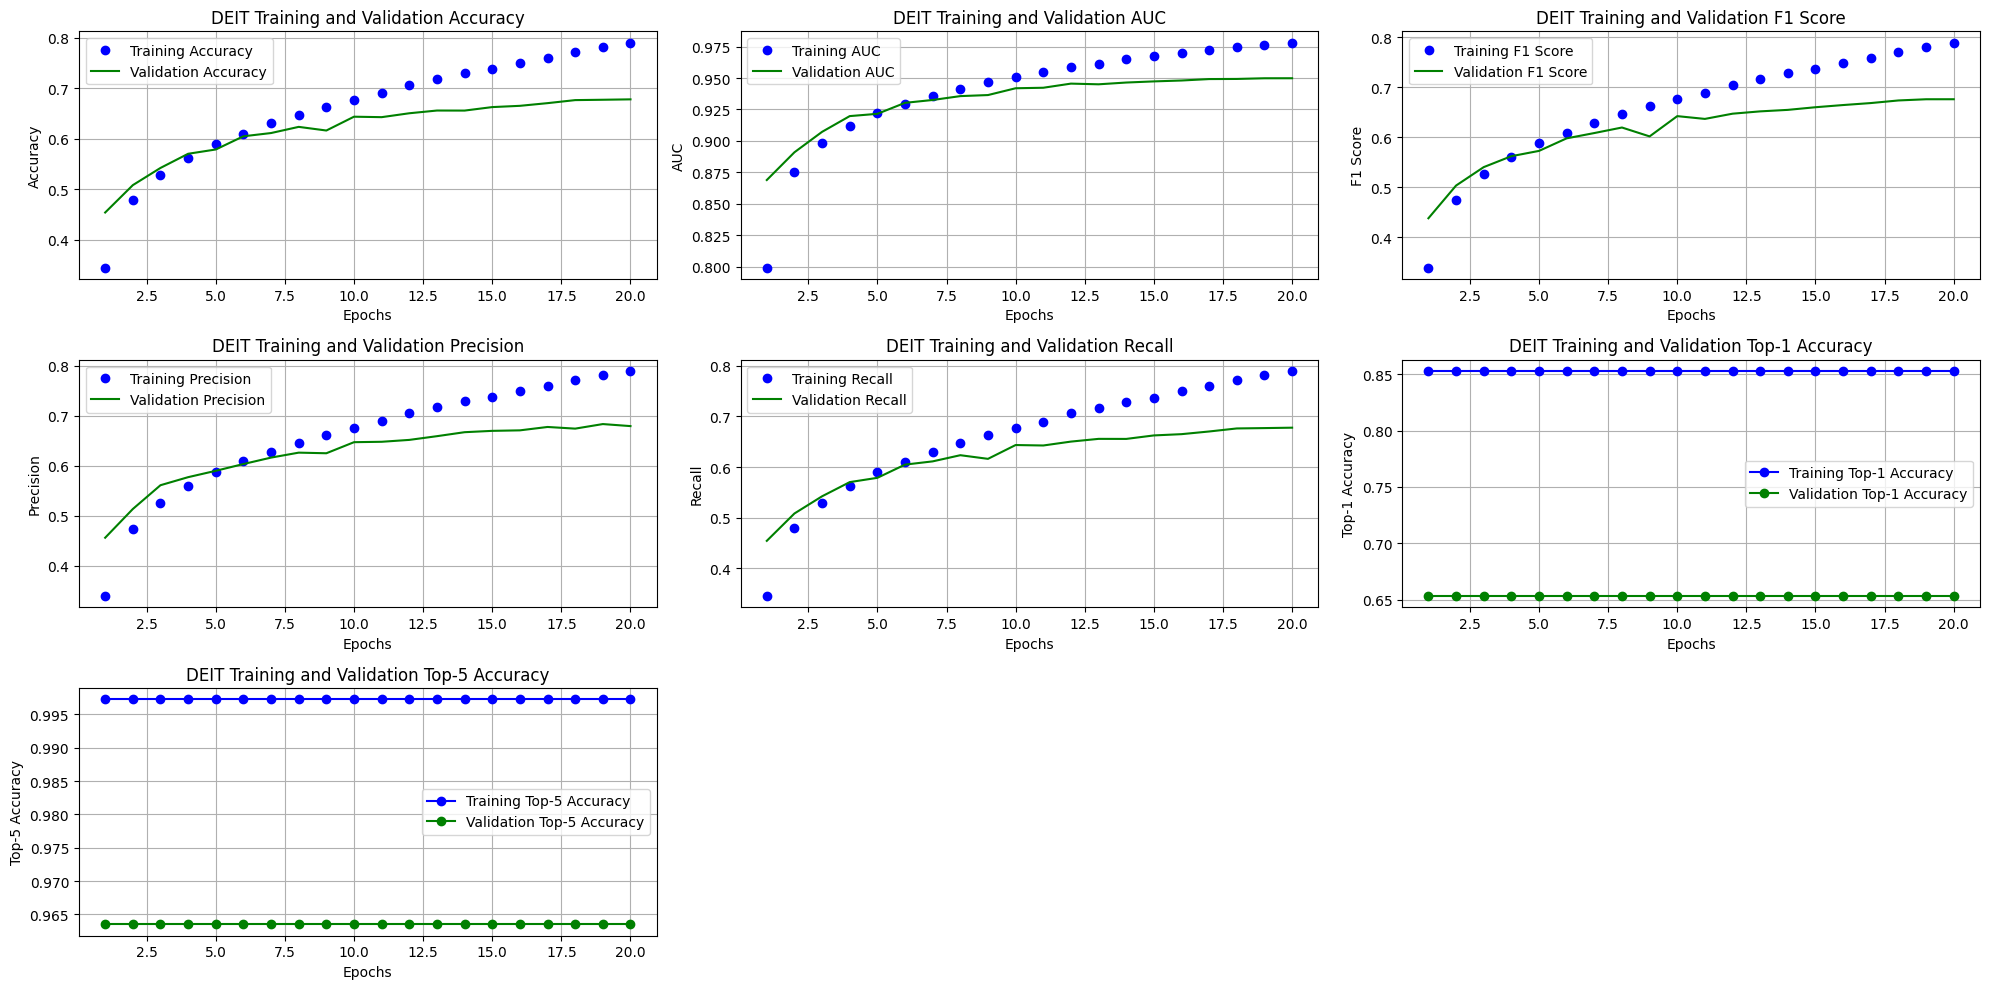

In [17]:
# Plot Accuracy, AUC, F1 Score, Precision, Recall
plt.figure(figsize=(20, 10))

# Plot Accuracy
plt.subplot(3, 3, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies_deit, 'bo', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies_deit, 'g', label='Validation Accuracy')
plt.title("DEIT Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Plot AUC
plt.subplot(3, 3, 2)
plt.plot(range(1, num_epochs + 1), train_aucs_deit, 'bo', label='Training AUC')
plt.plot(range(1, num_epochs + 1), val_aucs_deit, 'g', label='Validation AUC')
plt.title("DEIT Training and Validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.grid(True)
plt.legend()

# Plot F1 Score
plt.subplot(3, 3, 3)
plt.plot(range(1, num_epochs + 1), train_f1s_deit, 'bo', label='Training F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1s_deit, 'g', label='Validation F1 Score')
plt.title("DEIT Training and Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()

# Plot Precision
plt.subplot(3, 3, 4)
plt.plot(range(1, num_epochs + 1), train_precisions_deit, 'bo', label='Training Precision')
plt.plot(range(1, num_epochs + 1), val_precisions_deit, 'g', label='Validation Precision')
plt.title("DEIT Training and Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()

# Plot Recall
plt.subplot(3, 3, 5)
plt.plot(range(1, num_epochs + 1), train_recalls_deit, 'bo', label='Training Recall')
plt.plot(range(1, num_epochs + 1), val_recalls_deit, 'g', label='Validation Recall')
plt.title("DEIT Training and Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 6)
plt.plot(range(1, num_epochs + 1), train_top1_accuracies_deit, 'bo-', label='Training Top-1 Accuracy')
plt.plot(range(1, num_epochs + 1), val_top1_accuracies_deit, 'go-', label='Validation Top-1 Accuracy')
plt.title("DEIT Training and Validation Top-1 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Top-1 Accuracy")
plt.grid(True)
plt.legend()

# Plot Top-5 Accuracy
plt.subplot(3, 3, 7)
plt.plot(range(1, num_epochs + 1), train_top5_accuracies_deit, 'bo-', label='Training Top-5 Accuracy')
plt.plot(range(1, num_epochs + 1), val_top5_accuracies_deit, 'go-', label='Validation Top-5 Accuracy')
plt.title("DEIT Training and Validation Top-5 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Top-5 Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
print(train_recalls_deit)

[0.3448200225830078, 0.4785600006580353, 0.5283399820327759, 0.5620599985122681, 0.5898200273513794, 0.6101999878883362, 0.6303800344467163, 0.6467199921607971, 0.6626800298690796, 0.6774200201034546, 0.6896399855613708, 0.7060600519180298, 0.7172200083732605, 0.7294800281524658, 0.7374600172042847, 0.7497199773788452, 0.7594199776649475, 0.7711999416351318, 0.7810800075531006, 0.7900000214576721]


In [19]:
import os

# Save the entire ViT model
torch.save(model, r"F:\Studies\3rd semester\512 Computer Vision\Project\vit_entire_model.pth")

# Save the entire DeiT model
torch.save(student_model, r"F:\Studies\3rd semester\512 Computer Vision\Project\deit_entire_model.pth")


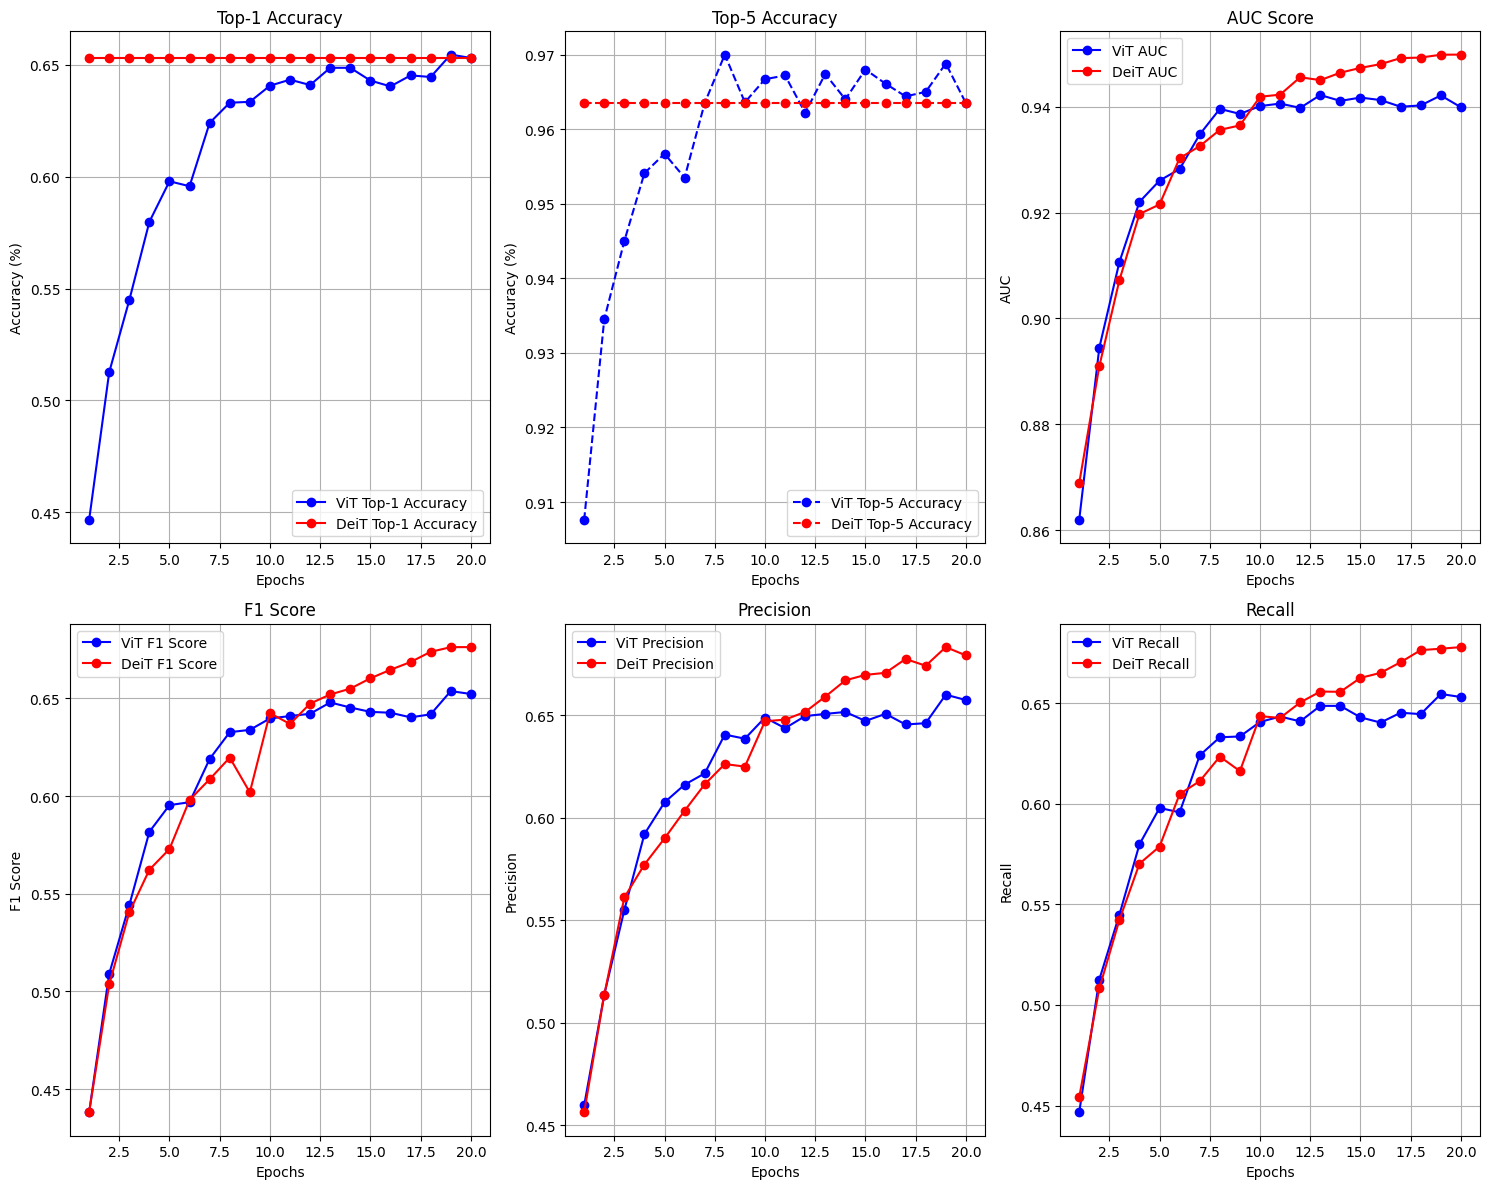

In [20]:
epochs = range(1, num_epochs + 1)

# Set up a large figure with subplots for each metric
plt.figure(figsize=(15, 12))

# 1. Plot Top-1 Accuracy
plt.subplot(2, 3, 1)
plt.plot(epochs, val_top1_accuracies, 'b-o', label='ViT Top-1 Accuracy')
plt.plot(epochs, val_top1_accuracies_deit, 'r-o', label='DeiT Top-1 Accuracy')
plt.title("Top-1 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

# 2. Plot Top-5 Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, val_top5_accuracies, 'b--o', label='ViT Top-5 Accuracy')
plt.plot(epochs, val_top5_accuracies_deit, 'r--o', label='DeiT Top-5 Accuracy')
plt.title("Top-5 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

# 3. Plot AUC
plt.subplot(2, 3, 3)
plt.plot(epochs, val_aucs, 'b-o', label='ViT AUC')
plt.plot(epochs, val_aucs_deit, 'r-o', label='DeiT AUC')
plt.title("AUC Score")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.grid(True)
plt.legend()

# 4. Plot F1 Score
plt.subplot(2, 3, 4)
plt.plot(epochs, val_f1s, 'b-o', label='ViT F1 Score')
plt.plot(epochs, val_f1s_deit, 'r-o', label='DeiT F1 Score')
plt.title("F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()

# 5. Plot Precision
plt.subplot(2, 3, 5)
plt.plot(epochs, val_precisions, 'b-o', label='ViT Precision')
plt.plot(epochs, val_precisions_deit, 'r-o', label='DeiT Precision')
plt.title("Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()

# 6. Plot Recall
plt.subplot(2, 3, 6)
plt.plot(epochs, val_recalls, 'b-o', label='ViT Recall')
plt.plot(epochs, val_recalls_deit, 'r-o', label='DeiT Recall')
plt.title("Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Data Augmentation for Deit

In [21]:
# # Define data augmentations
# train_transforms = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with CIFAR-10 mean and std
# ])

# # Cutmix and Mixup??

# Rand Augment ✗ 9/0.5
# Mixup prob. ✗ 0.8
# Cutmix prob. ✗ 1.0
# Erasing prob. ✗ 0.25
# Table 9: Ingredients and hyper-parameters for our met

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy, MulticlassAUROC, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations with Random Erasing (Cutout) and other augmentations
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))  # Random Erasing (Cutout)
])


In [23]:
# Custom dataset wrapper for repeated augmentation
class RepeatedAugmentationDataset(Dataset):
    def __init__(self, dataset, num_repeats=3):
        self.dataset = dataset
        self.num_repeats = num_repeats
    
    def __len__(self):
        return len(self.dataset) * self.num_repeats
    
    def __getitem__(self, idx):
        original_idx = idx % len(self.dataset)
        return self.dataset[original_idx]

# Load CIFAR-10 dataset with repeated augmentations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# train_dataset = RepeatedAugmentationDataset(original_train_dataset, num_repeats=3)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Define CutMix and MixUp
def cutmix(data, targets, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size(-1) * data.size(-2)))
    return data, targets, shuffled_targets, lam

def mixup(data, targets, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    data = lam * data + (1 - lam) * shuffled_data
    return data, targets, shuffled_targets, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


Files already downloaded and verified
Files already downloaded and verified


In [24]:
# Define metrics
num_classes = 10  # For CIFAR-10

accuracy_metric_aug = MulticlassAccuracy(num_classes=num_classes).to(device)
auc_metric_aug = MulticlassAUROC(num_classes=num_classes).to(device)
f1_metric_aug = MulticlassF1Score(num_classes=num_classes).to(device)
precision_metric_aug = MulticlassPrecision(num_classes=num_classes).to(device)
recall_metric_aug = MulticlassRecall(num_classes=num_classes).to(device)
top1_accuracy_metric_aug = MulticlassAccuracy(num_classes=num_classes, top_k=1).to(device)
top5_accuracy_metric_aug = MulticlassAccuracy(num_classes=num_classes, top_k=5).to(device)

In [25]:
# Define the training function with CutMix, MixUp, and Random Erasing
def train_distilled_with_augmentations(model, teacher, dataloader, criterion, optimizer, use_cutmix=True, use_mixup=True, alpha=1.0):
    model.train()
    total_loss = 0

    accuracy_metric_aug.reset()
    auc_metric_aug.reset()
    f1_metric_aug.reset()
    precision_metric_aug.reset()
    recall_metric_aug.reset()
    top1_accuracy_metric_aug.reset()
    top5_accuracy_metric_aug.reset()
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)


        # Set a chance for each augmentation
        if np.random.rand() < 0.001:
            # Apply CutMix 
            images, labels, shuffled_labels, lam = cutmix(images, labels, alpha=alpha)
            student_logits, student_distill_logits = model(images)
            loss = lam * criterion(student_logits, student_distill_logits, teacher(images), labels) + \
                   (1 - lam) * criterion(student_logits, student_distill_logits, teacher(images), shuffled_labels)
        elif np.random.rand() < 0.001:
            # Apply MixUp 
            images, labels, shuffled_labels, lam = mixup(images, labels, alpha=alpha)
            student_logits, student_distill_logits = model(images)
            loss = lam * criterion(student_logits, student_distill_logits, teacher(images), labels) + \
                   (1 - lam) * criterion(student_logits, student_distill_logits, teacher(images), shuffled_labels)
        else:
            # Standard forward pass 
            student_logits, student_distill_logits = model(images)
            loss = criterion(student_logits, student_distill_logits, teacher(images), labels)
      

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        preds = student_logits.argmax(1) # Predictions for metrics like accuracy, F1, precision, and recall
        probs = torch.softmax(student_logits, dim=1)  # Probabilities for AUC
        
        # Update metrics
        accuracy_metric_aug.update(preds, labels)
        auc_metric_aug.update(probs, labels)
        f1_metric_aug.update(preds, labels)
        precision_metric_aug.update(preds, labels)
        recall_metric_aug.update(preds, labels)
        top1_accuracy_metric_aug.update(student_logits, labels)
        top5_accuracy_metric_aug.update(student_logits, labels)
    
    avg_loss_aug = total_loss / len(dataloader)
    train_accuracy_aug = accuracy_metric_aug.compute()
    train_auc_aug = auc_metric_aug.compute()
    train_f1_aug = f1_metric_aug.compute()
    train_precision_aug = precision_metric_aug.compute()
    train_recall_aug = recall_metric_aug.compute()
    train_top1_accuracy_aug = top1_accuracy_metric_aug.compute().item()
    train_top5_accuracy_aug = top5_accuracy_metric_aug.compute().item()
    return avg_loss_aug, train_accuracy_aug.item(), train_auc_aug.item(), train_f1_aug.item(), train_precision_aug.item(), train_recall_aug.item(),  train_top1_accuracy_aug, train_top5_accuracy_aug
    


In [26]:
def evaluate_distilled_with_augmentations(model, teacher, dataloader, criterion):
    model.eval()
    total_loss = 0

    # Reset metric values
    accuracy_metric_aug.reset()
    auc_metric_aug.reset()
    f1_metric_aug.reset()
    precision_metric_aug.reset()
    recall_metric_aug.reset()
    top1_accuracy_metric_aug.reset()
    top5_accuracy_metric_aug.reset()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            student_logits, student_distill_logits = model(images)
            loss = criterion(student_logits, student_distill_logits, teacher(images), labels)
            
            # Accumulate loss
            total_loss += loss.item()

            # Predictions and probabilities for metrics
            preds = student_logits.argmax(1)  # Discrete predictions
            probs = torch.softmax(student_logits, dim=1)  # Probabilities for AUC
            
            # Update metrics
            accuracy_metric_aug.update(preds, labels)
            auc_metric_aug.update(probs, labels)
            f1_metric_aug.update(preds, labels)
            precision_metric_aug.update(preds, labels)
            recall_metric_aug.update(preds, labels)
            top1_accuracy_metric_aug.update(student_logits, labels)
            top5_accuracy_metric_aug.update(student_logits, labels)

    # Calculate average loss and all metrics for the epoch
    avg_loss_aug = total_loss / len(dataloader)
    val_accuracy_aug = accuracy_metric_aug.compute()
    val_auc_aug = auc_metric_aug.compute()
    val_f1_aug = f1_metric_aug.compute()
    val_precision_aug = precision_metric_aug.compute()
    val_recall_aug = recall_metric_aug.compute()
    val_top1_accuracy_aug = top1_accuracy_metric_aug.compute().item()
    val_top5_accuracy_aug = top5_accuracy_metric_aug.compute().item()
    
    return avg_loss_aug, val_accuracy_aug.item(), val_auc_aug.item(), val_f1_aug.item(), val_precision_aug.item(), val_recall_aug.item(), val_top1_accuracy_aug, val_top5_accuracy_aug


In [27]:
# Lists to store training and validation history for all metrics with data augmentation
train_losses_aug, train_accuracies_aug, train_aucs_aug, train_f1s_aug, train_precisions_aug, train_recalls_aug = [], [], [], [], [], []
val_losses_aug, val_accuracies_aug, val_aucs_aug, val_f1s_aug, val_precisions_aug, val_recalls_aug = [], [], [], [], [], []
train_top1_accuracies_aug, val_top1_accuracies_aug = [], []
train_top5_accuracies_aug, val_top5_accuracies_aug = [], []

num_epochs = 20
for epoch in range(num_epochs):
    # Training with data augmentation (CutMix, MixUp, Random Erasing, etc.)
    print(f"Epoch {epoch+1}/{num_epochs} - Training")
    train_loss_aug, train_accuracy_aug, train_auc_aug, train_f1_aug, train_precision_aug, train_recall_aug, train_top1_accuracy_aug, train_top5_accuracy_aug = \
        train_distilled_with_augmentations(student_model, teacher_model, train_loader, criterion, optimizer, use_cutmix=True, use_mixup=True, alpha=1.0)
    
    # Validation without data augmentation
    print(f"Epoch {epoch+1}/{num_epochs} - Validation")
    val_loss_aug, val_accuracy_aug, val_auc_aug, val_f1_aug, val_precision_aug, val_recall_aug, val_top1_accuracy_aug, val_top5_accuracy_aug = \
        evaluate_distilled_with_augmentations(student_model, teacher_model, test_loader, criterion)
    
    # Store training history
    train_losses_aug.append(train_loss_aug)
    train_accuracies_aug.append(train_accuracy_aug)
    train_aucs_aug.append(train_auc_aug)
    train_f1s_aug.append(train_f1_aug)
    train_precisions_aug.append(train_precision_aug)
    train_recalls_aug.append(train_recall_aug)
    train_top1_accuracies_aug.append(train_top1_accuracy_aug)
    train_top5_accuracies_aug.append(train_top5_accuracy_aug)
    
    # Store validation history
    val_losses_aug.append(val_loss_aug)
    val_accuracies_aug.append(val_accuracy_aug)
    val_aucs_aug.append(val_auc_aug)
    val_f1s_aug.append(val_f1_aug)
    val_precisions_aug.append(val_precision_aug)
    val_recalls_aug.append(val_recall_aug)
    val_top1_accuracies_aug.append(val_top1_accuracy_aug)
    val_top5_accuracies_aug.append(val_top5_accuracy_aug)
    
    # Print epoch metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss_aug:.4f}, Train Acc: {train_accuracy_aug:.4f}, Train AUC: {train_auc_aug:.4f}, "
          f"Train F1: {train_f1_aug:.4f}, Train Precision: {train_precision_aug:.4f}, Train Recall: {train_recall_aug:.4f}, "
          f"Train Top-1 Acc: {train_top1_accuracy_aug:.4f}, Train Top-5 Acc: {train_top5_accuracy_aug:.4f} - "
          f"Val Loss: {val_loss_aug:.4f}, Val Acc: {val_accuracy_aug:.4f}, Val AUC: {val_auc_aug:.4f}, "
          f"Val F1: {val_f1_aug:.4f}, Val Precision: {val_precision_aug:.4f}, Val Recall: {val_recall_aug:.4f}, "
          f"Val Top-1 Acc: {val_top1_accuracy_aug:.4f}, Val Top-5 Acc: {val_top5_accuracy_aug:.4f}")


Epoch 1/20 - Training
Epoch 1/20 - Validation
Epoch [1/20] - Train Loss: 0.6744, Train Acc: 0.5381, Train AUC: 0.8999, Train F1: 0.5360, Train Precision: 0.5350, Train Recall: 0.5381, Train Top-1 Acc: 0.5381, Train Top-5 Acc: 0.9367 - Val Loss: 0.6487, Val Acc: 0.5495, Val AUC: 0.9134, Val F1: 0.5491, Val Precision: 0.5751, Val Recall: 0.5495, Val Top-1 Acc: 0.5495, Val Top-5 Acc: 0.9493
Epoch 2/20 - Training
Epoch 2/20 - Validation
Epoch [2/20] - Train Loss: 0.6131, Train Acc: 0.5763, Train AUC: 0.9169, Train F1: 0.5742, Train Precision: 0.5733, Train Recall: 0.5763, Train Top-1 Acc: 0.5763, Train Top-5 Acc: 0.9516 - Val Loss: 0.6116, Val Acc: 0.5743, Val AUC: 0.9228, Val F1: 0.5668, Val Precision: 0.5938, Val Recall: 0.5743, Val Top-1 Acc: 0.5743, Val Top-5 Acc: 0.9555
Epoch 3/20 - Training
Epoch 3/20 - Validation
Epoch [3/20] - Train Loss: 0.5904, Train Acc: 0.5937, Train AUC: 0.9235, Train F1: 0.5919, Train Precision: 0.5911, Train Recall: 0.5937, Train Top-1 Acc: 0.5937, Train Top

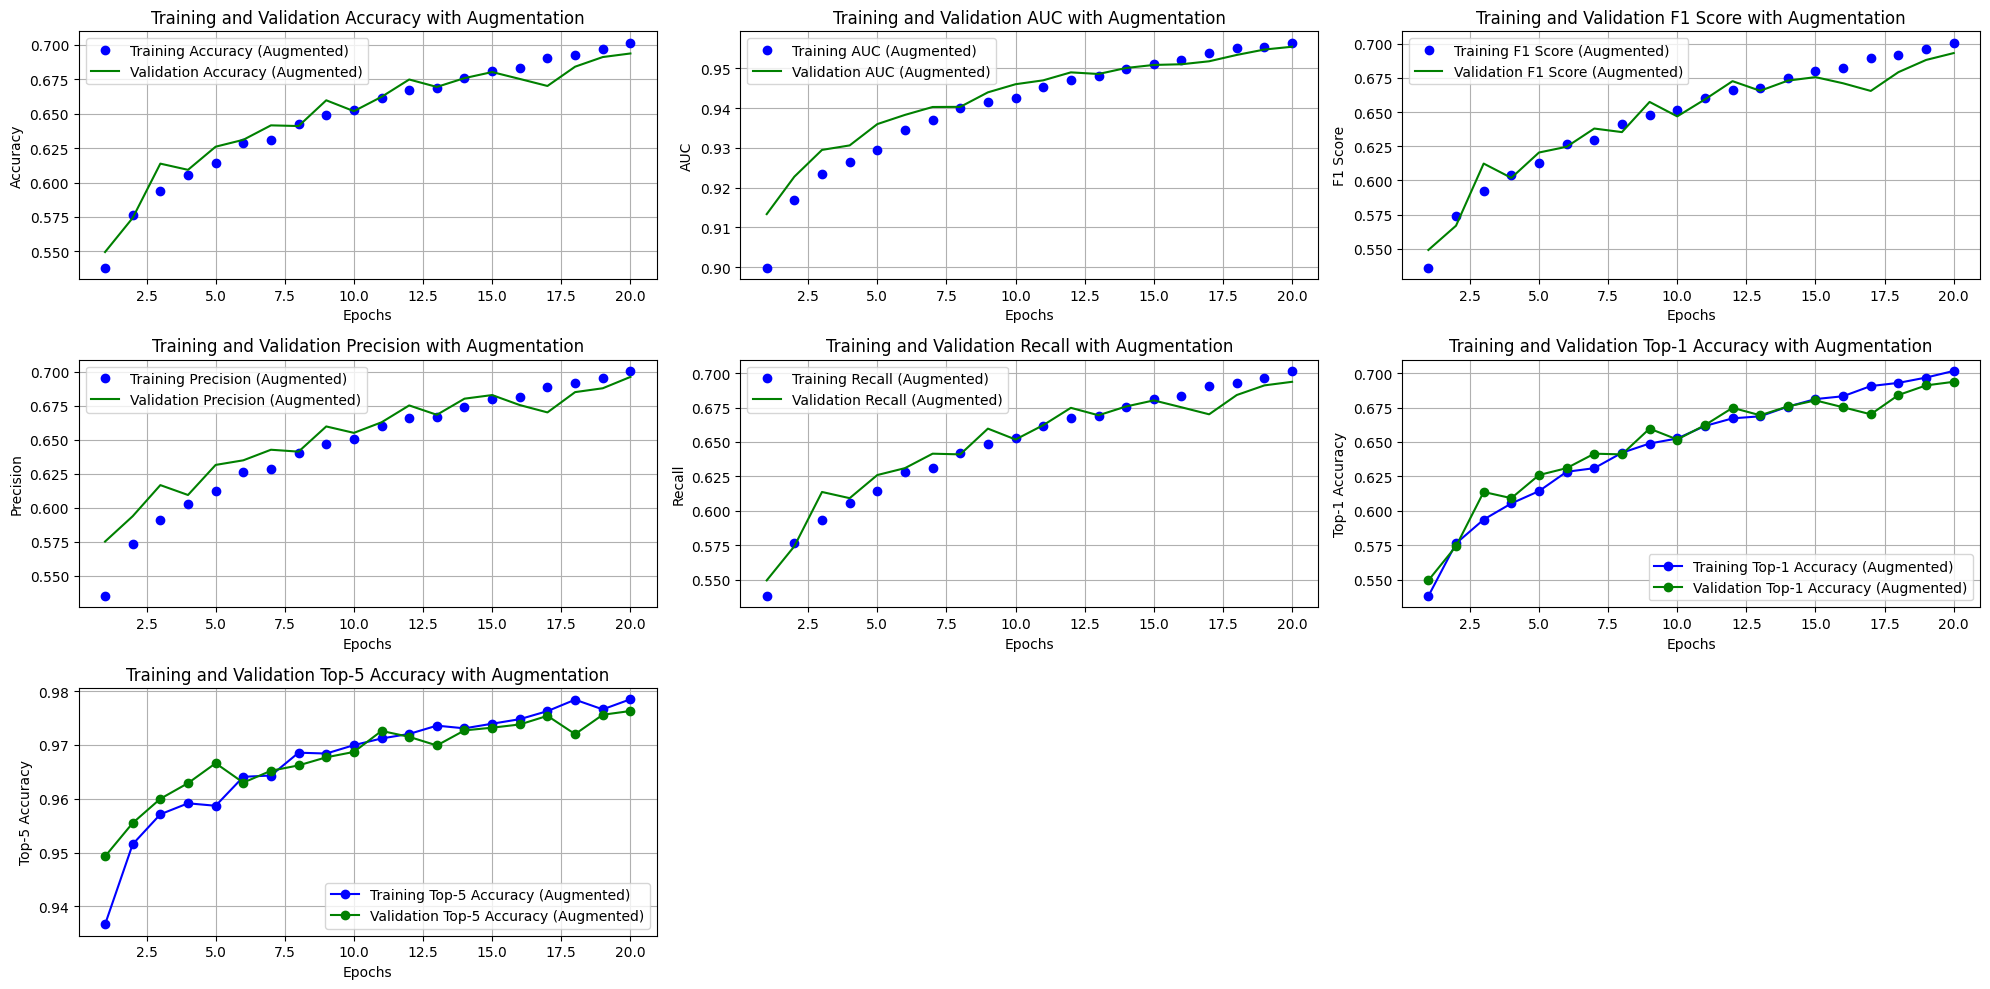

In [28]:
# Plot Accuracy, AUC, F1 Score, Precision, Recall for DeiT with Augmentation
plt.figure(figsize=(20, 10))

# Plot Accuracy
plt.subplot(3, 3, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies_aug, 'bo', label='Training Accuracy (Augmented)')
plt.plot(range(1, num_epochs + 1), val_accuracies_aug, 'g', label='Validation Accuracy (Augmented)')
plt.title("Training and Validation Accuracy with Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Plot AUC
plt.subplot(3, 3, 2)
plt.plot(range(1, num_epochs + 1), train_aucs_aug, 'bo', label='Training AUC (Augmented)')
plt.plot(range(1, num_epochs + 1), val_aucs_aug, 'g', label='Validation AUC (Augmented)')
plt.title("Training and Validation AUC with Augmentation")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.grid(True)
plt.legend()

# Plot F1 Score
plt.subplot(3, 3, 3)
plt.plot(range(1, num_epochs + 1), train_f1s_aug, 'bo', label='Training F1 Score (Augmented)')
plt.plot(range(1, num_epochs + 1), val_f1s_aug, 'g', label='Validation F1 Score (Augmented)')
plt.title("Training and Validation F1 Score with Augmentation")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()

# Plot Precision
plt.subplot(3, 3, 4)
plt.plot(range(1, num_epochs + 1), train_precisions_aug, 'bo', label='Training Precision (Augmented)')
plt.plot(range(1, num_epochs + 1), val_precisions_aug, 'g', label='Validation Precision (Augmented)')
plt.title("Training and Validation Precision with Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()

# Plot Recall
plt.subplot(3, 3, 5)
plt.plot(range(1, num_epochs + 1), train_recalls_aug, 'bo', label='Training Recall (Augmented)')
plt.plot(range(1, num_epochs + 1), val_recalls_aug, 'g', label='Validation Recall (Augmented)')
plt.title("Training and Validation Recall with Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()

# Plot Top-1 Accuracy
plt.subplot(3, 3, 6)
plt.plot(range(1, num_epochs + 1), train_top1_accuracies_aug, 'bo-', label='Training Top-1 Accuracy (Augmented)')
plt.plot(range(1, num_epochs + 1), val_top1_accuracies_aug, 'go-', label='Validation Top-1 Accuracy (Augmented)')
plt.title("Training and Validation Top-1 Accuracy with Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Top-1 Accuracy")
plt.grid(True)
plt.legend()

# Plot Top-5 Accuracy
plt.subplot(3, 3, 7)
plt.plot(range(1, num_epochs + 1), train_top5_accuracies_aug, 'bo-', label='Training Top-5 Accuracy (Augmented)')
plt.plot(range(1, num_epochs + 1), val_top5_accuracies_aug, 'go-', label='Validation Top-5 Accuracy (Augmented)')
plt.title("Training and Validation Top-5 Accuracy with Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Top-5 Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


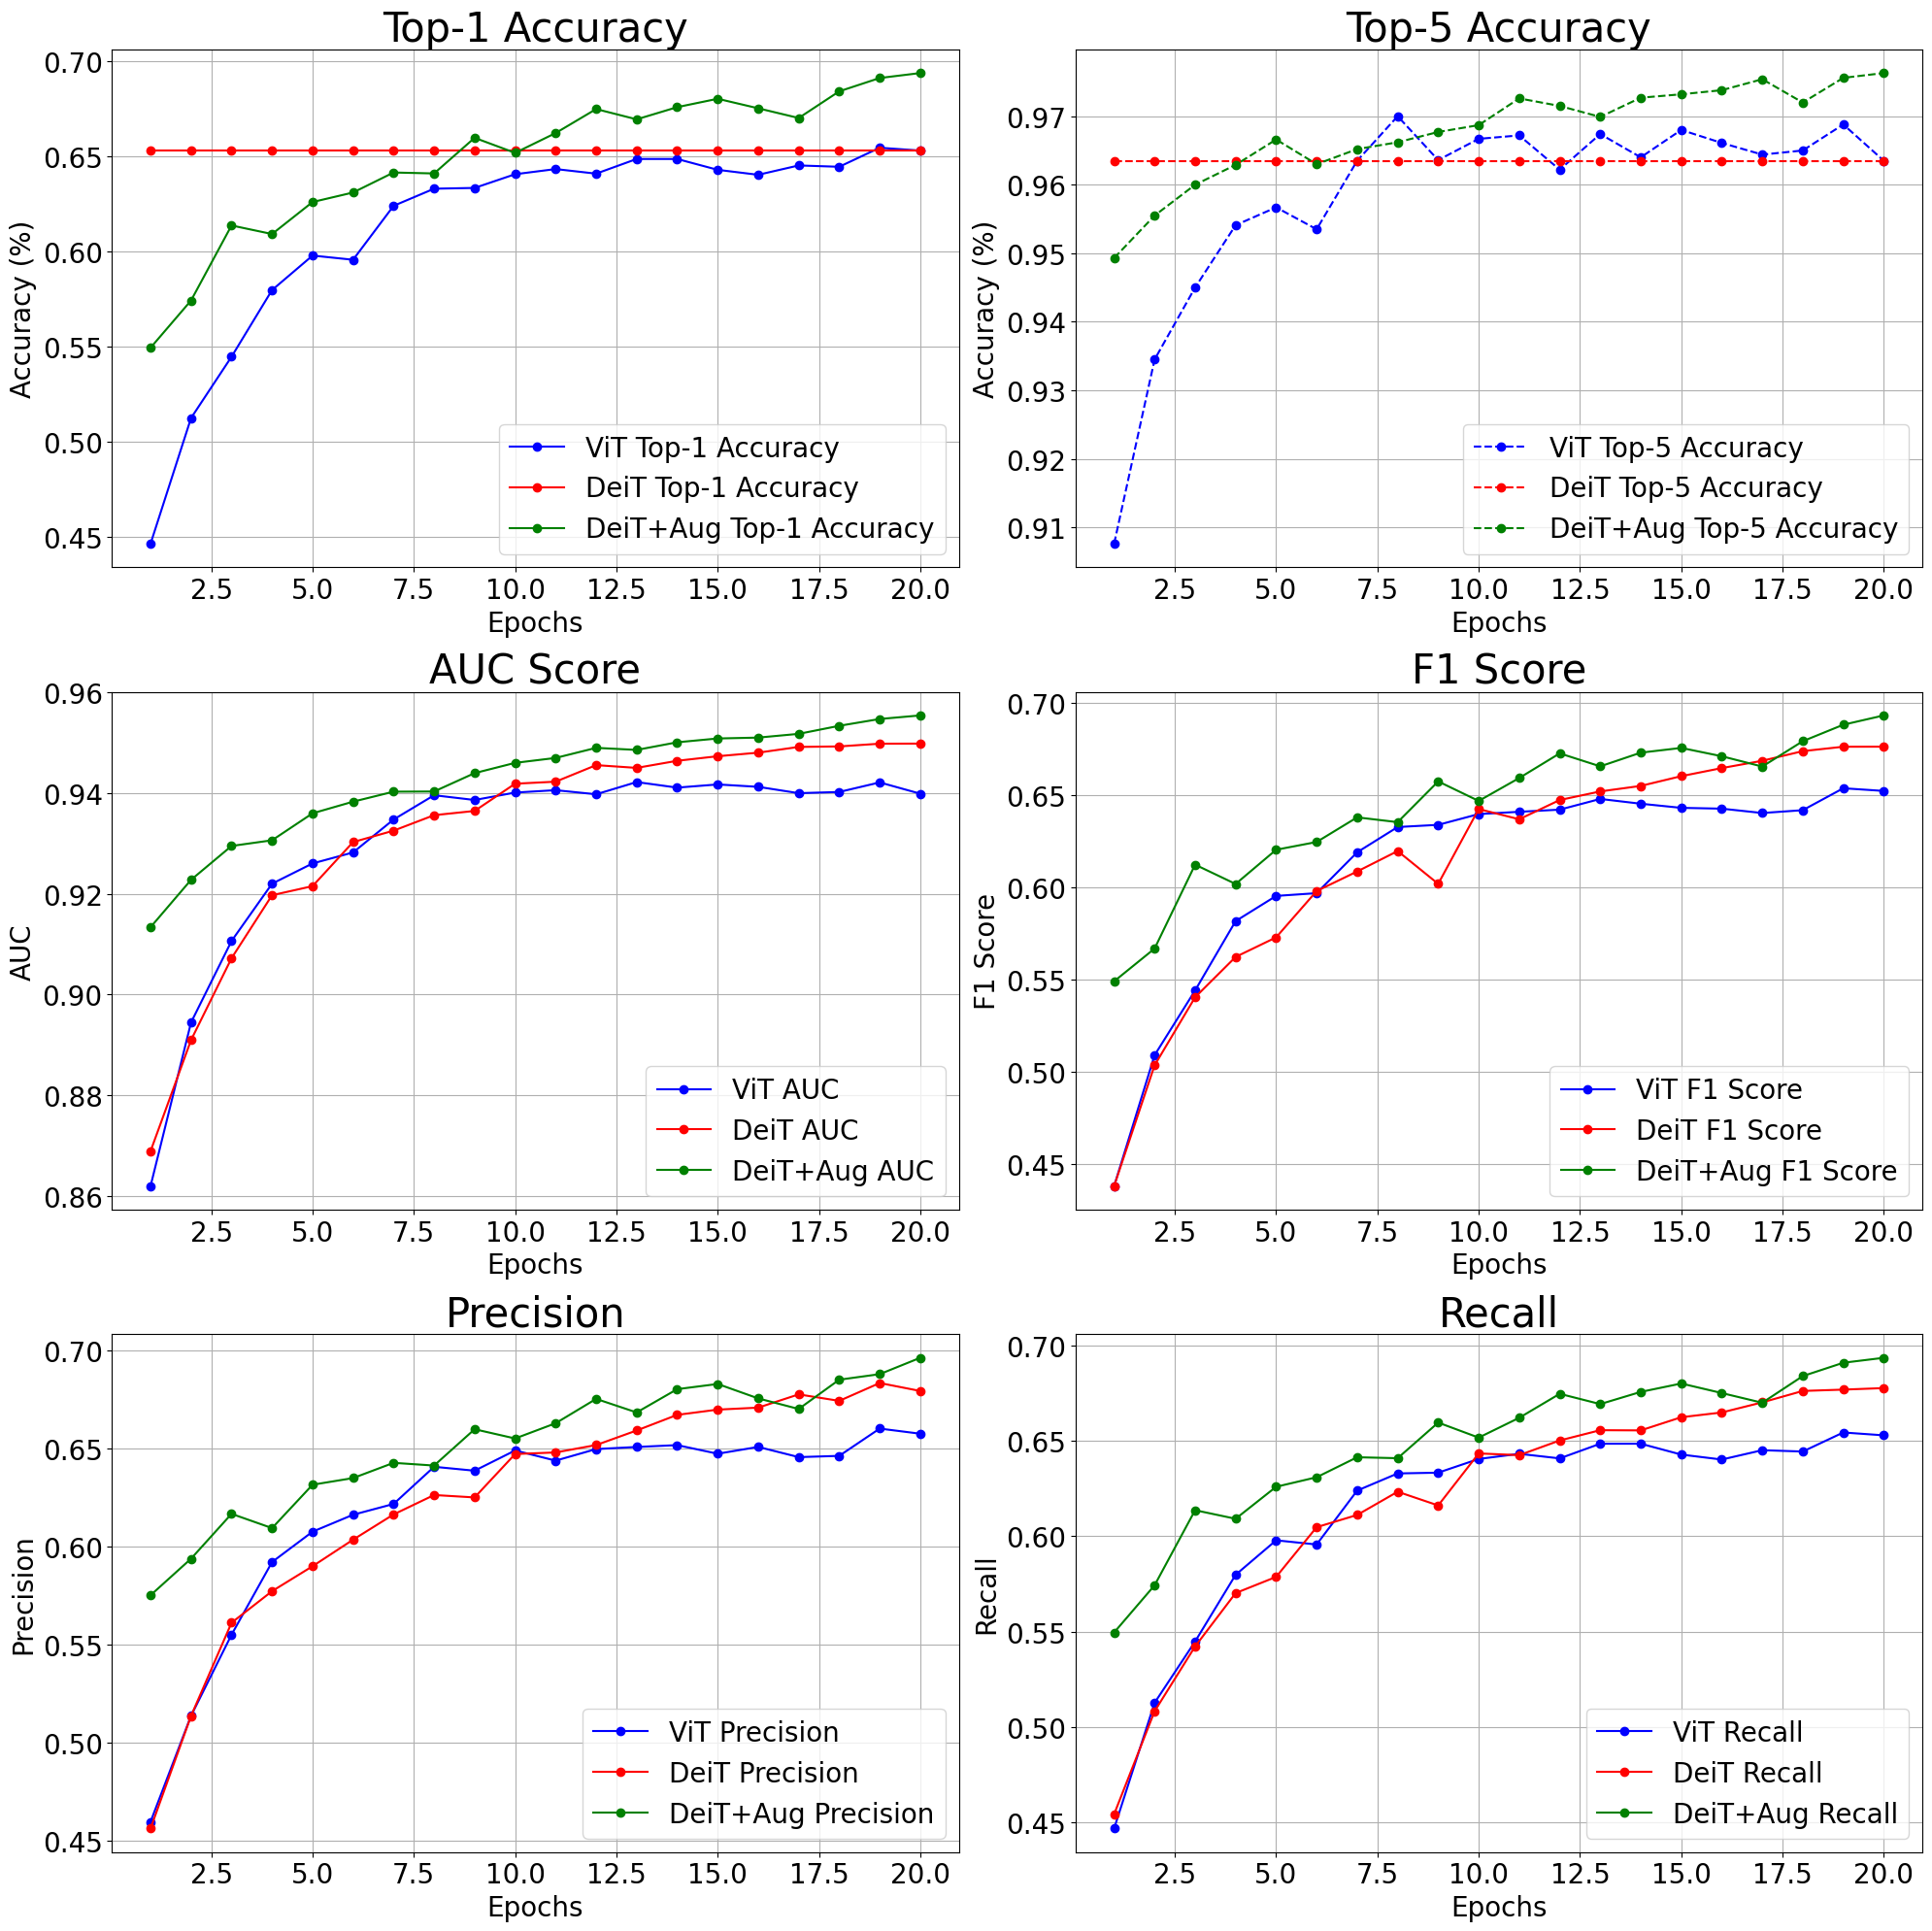

In [29]:
epochs = range(1, num_epochs + 1)


plt.figure(figsize=(20, 20))

# 1. Plot Top-1 Accuracy
plt.subplot(3, 2, 1)
plt.plot(epochs, val_top1_accuracies, 'b-o', label='ViT Top-1 Accuracy')
plt.plot(epochs, val_top1_accuracies_deit, 'r-o', label='DeiT Top-1 Accuracy')
plt.plot(epochs, val_top1_accuracies_aug, 'g-o', label='DeiT+Aug Top-1 Accuracy')
plt.title("Top-1 Accuracy", fontsize=30)
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Accuracy (%)", fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)  

# 2. Plot Top-5 Accuracy
plt.subplot(3, 2, 2)
plt.plot(epochs, val_top5_accuracies, 'b--o', label='ViT Top-5 Accuracy')
plt.plot(epochs, val_top5_accuracies_deit, 'r--o', label='DeiT Top-5 Accuracy')
plt.plot(epochs, val_top5_accuracies_aug, 'g--o', label='DeiT+Aug Top-5 Accuracy')
plt.title("Top-5 Accuracy", fontsize=30)
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Accuracy (%)",fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)

# 3. Plot AUC
plt.subplot(3, 2, 3)
plt.plot(epochs, val_aucs, 'b-o', label='ViT AUC')
plt.plot(epochs, val_aucs_deit, 'r-o', label='DeiT AUC')
plt.plot(epochs, val_aucs_aug, 'g-o', label='DeiT+Aug AUC')
plt.title("AUC Score", fontsize=30)
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("AUC",fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)

# 4. Plot F1 Score
plt.subplot(3, 2, 4)
plt.plot(epochs, val_f1s, 'b-o', label='ViT F1 Score')
plt.plot(epochs, val_f1s_deit, 'r-o', label='DeiT F1 Score')
plt.plot(epochs, val_f1s_aug, 'g-o', label='DeiT+Aug F1 Score')
plt.title("F1 Score", fontsize=30)
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("F1 Score",fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)

# 5. Plot Precision
plt.subplot(3, 2, 5)
plt.plot(epochs, val_precisions, 'b-o', label='ViT Precision')
plt.plot(epochs, val_precisions_deit, 'r-o', label='DeiT Precision')
plt.plot(epochs, val_precisions_aug, 'g-o', label='DeiT+Aug Precision')
plt.title("Precision", fontsize=30)
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Precision",fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)

# 6. Plot Recall
plt.subplot(3, 2, 6)
plt.plot(epochs, val_recalls, 'b-o', label='ViT Recall')
plt.plot(epochs, val_recalls_deit, 'r-o', label='DeiT Recall')
plt.plot(epochs, val_recalls_aug, 'g-o', label='DeiT+Aug Recall')
plt.title("Recall", fontsize=30)
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Recall",fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()
